# Variational GP on an CMB Image
## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import sys
sys.path.append("..")
from vgp.vgp import VGPsqExp
from datetime import datetime
import math

## Load file

In [2]:
im0 = pd.read_csv("data/comm18_cut_masked_id0.txt", sep=" ", header=None)
N = int(math.sqrt(im0.shape[0]))
im0.head()

,0,1,2
0,0.0,0.0,266.0
1,0.0,1.0,256.0
2,0.0,2.0,203.0
3,0.0,3.0,106.0
4,0.0,4.0,136.0


## Split data into training and test sets

In [3]:
from sklearn.model_selection import train_test_split
X = im0[[0, 1]].to_numpy()
y = im0[2].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)
y_train = y_train.reshape((y_train.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

## Distribution of the values

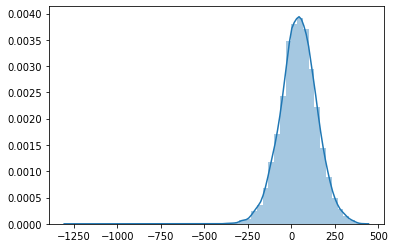

In [4]:
sns.distplot(y)

## Minimum value

In [5]:
min(y)

-1260.0

## Location where the minimum occurs

In [6]:
X[y==min(y),:]

array([[11., 59.]])

## Visualize image

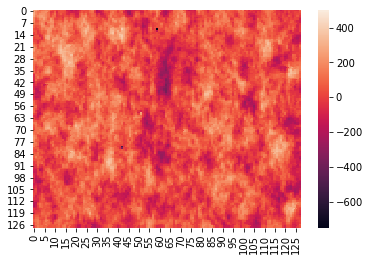

In [7]:
sns.heatmap(y.reshape(N,N), vmin=-750, vmax=500)

## RMSE on test set based on prediction by mean
Can be treated as the benchmark which can be compared to the RMSE based on GP.

In [8]:
m = y_train.mean()
print(np.linalg.norm(y_test - m)/math.sqrt(y_test.shape[0]))

103.15580272799336


## Test Variational GP with different numbers of inducing inputs

### Method for generating equally spaced inducing inputs

In [9]:
def inducingInputsGenerator(X, sqrtNumInduce):
    p = np.linspace(0, 1, sqrtNumInduce+2)[1:sqrtNumInduce+1]
    quantiles = np.quantile(X, p, axis=0)
    X_inducing = np.zeros((sqrtNumInduce*sqrtNumInduce, 2))
    for i in range(sqrtNumInduce):
        for j in range(sqrtNumInduce):
            index_num = sqrtNumInduce*i + j
            X_inducing[index_num, 0] = quantiles[i, 0]
            X_inducing[index_num, 1] = quantiles[j, 1]
    
    return X_inducing

### Train the model with different numbers of inducing inputs and compute test RMSE's

In [10]:
sigmaSqf = 0.01
lscale = 0.01
varErr = 1

elapsedTimes = []
errs = []

mSqrt = [1, 10, 18, 23, 29, 32, 35, 39, 43]
for sqrtNumInduce in mSqrt:
    X_inducing = inducingInputsGenerator(X, sqrtNumInduce)
            
    gpImage = VGPsqExp(X_train,
                        y_train,
                        X_inducing,
                        sigmaSqf,
                        lscale,
                        varErr)
    #gpImage.optimizeHyperparams(showPath=False)
    t = gpImage.train(returnElapsedTime=True)
    elapsedTimes.append(t)
    
    print("sqrt(m)="+str(sqrtNumInduce), end=": ")
    pred = gpImage.predictMean(X_test, 
                          y_test, 
                          True)
    errs.append(np.linalg.norm(pred-y_test)/math.sqrt(pred.shape[0]))

sqrt(m)=1: Test RMSE=103.16883550207204.
sqrt(m)=10: Test RMSE=86.03181205739409.
sqrt(m)=18: Test RMSE=69.13860450009172.
sqrt(m)=23: Test RMSE=58.10509968934316.
sqrt(m)=29: Test RMSE=51.31062948897339.
sqrt(m)=32: Test RMSE=48.99445741903052.
sqrt(m)=35: Test RMSE=48.205154772071886.
sqrt(m)=39: Test RMSE=47.37567177330898.
sqrt(m)=43: Test RMSE=46.89336529781874.


### Plot of test RMSE vs num of inducing inputs

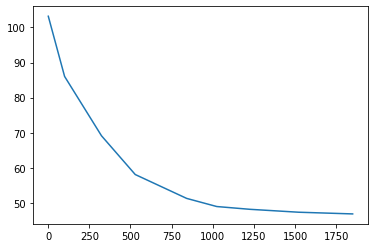

In [11]:
m = list(map(lambda x: x**2, mSqrt))
sns.lineplot(x=m, y=errs)

### Plot of Elapsed time for training vs sqrt of the num of inducing inputs

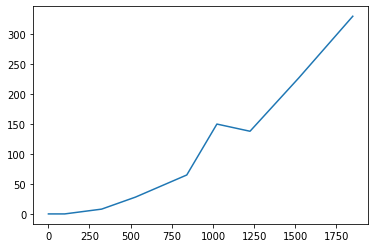

In [12]:
sns.lineplot(x=m, y=elapsedTimes)

## Test the method (with 50^2=2500 inducing inputs)
Inducing inputs are taken to be equally spaced points in the grid.

### Training

In [13]:
X_inducing = inducingInputsGenerator(X, 50)
sigmaSqf = 0.0001
lscale = 0.01
varErr = 0.00001

gpImage = VGPsqExp(X_train,
                    y_train,
                    X_inducing,
                    sigmaSqf,
                    lscale,
                    varErr)
gpImage.train(printElapsedTime=True)

Elapsed Time (in Seconds): 621


### Make predictions on the test set and print RMSE

In [14]:
pred = gpImage.predictMean(X_test, y_test, True)

Test RMSE=42.54302552904445.


### Reproduce image based on the mean prediction at each point in the grid

In [15]:
pred_image = gpImage.predictMean(X, y)

### Visualize the reproduced image

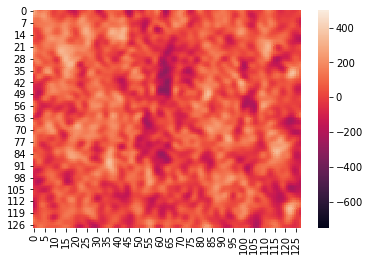

In [16]:
sns.heatmap(pred_image.reshape(N,N), vmin=-750, vmax=500)

## Reproduce image based on the trained model with a very small length scale

In [17]:
lscale = 0.000000001

gpImage = VGPsqExp(X_train,
                    y_train,
                    X_inducing,
                    sigmaSqf,
                    lscale,
                    varErr)
gpImage.train(printElapsedTime=True)

Elapsed Time (in Seconds): 525


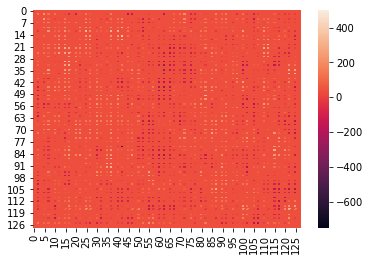

In [18]:
pred_image = gpImage.predictMean(X, y)
sns.heatmap(pred_image.reshape(N,N), vmin=-750, vmax=500)